### Import packages

In [1]:
import numpy as np
import yaml
from gmm_mi.gmm import GMM
from gmm_mi.gmm_mi import GMM_MI
from gmm_mi.data.synthetic_data import D5p as dataset
from gmm_mi.utils.plotting import plot_gmm_contours, plot_bias_chi2_histogram

### Calculate the true MI of the synthetic model, and plot contours

True MI: 0.180 nats


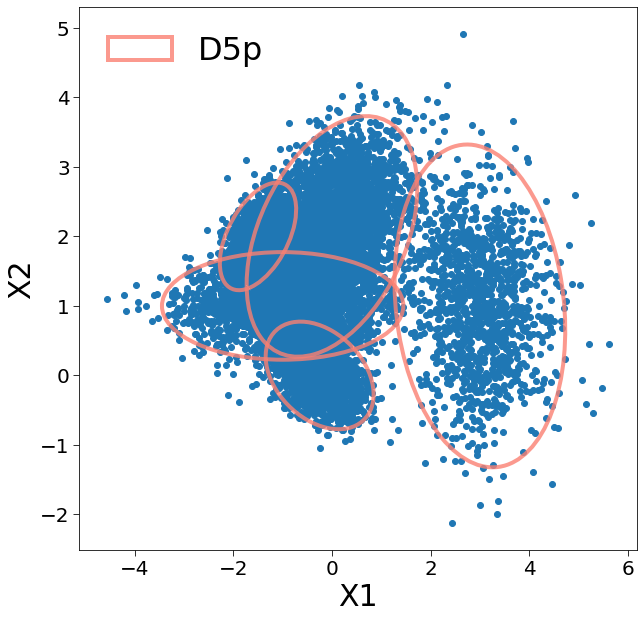

In [2]:
label = 'D5p'
analytic = np.load(f'./MI_synthetic_datasets/MI_{label}.npy')
print(f'True MI: {analytic:.3f} nats')
plot_gmm_contours(dataset, ls='-', label=label)

### Test on 500 trials

In [3]:
run_this_cell = False

if not run_this_cell:
    print('Not running this cell...')
    pass
else:
    random_states = 501
    N = 10000
    print(f'Running {random_states} trials...')
    all_MI_estimates = np.zeros((random_states, 2))
    save = False

    # load parameters from yaml file and assign them to variables
    # not the cleanest and safest way, but it should work
    with open('./config_parameters.yml', 'rb') as f:
        conf = yaml.safe_load(f.read())
    locals().update(conf)
    # change two hyperparameters
    init_type = "random_sklearn"
    tol = 1e-6

    # true GMM parameters
    n_components = dataset.n_components 
    true_weights = dataset.weights_
    true_means = dataset.means_
    true_covariances = dataset.covariances_

    import time
    init_time = time.time()

    for r in range(random_states):
        # create different realisation of ground truth; note the different random_state each time
        X = GMM(n_components=n_components, weights_init=true_weights, 
                          means_init=true_means, covariances_init=true_covariances, 
                          random_state=r).sample(N)[0]

        MI_mean, MI_std = GMM_MI(X, n_folds=n_folds, n_inits=n_inits, init_type=init_type, reg_covar=reg_covar, 
                                 tol=tol, max_iter=max_iter, bootstrap=bootstrap, n_bootstrap=n_bootstrap, 
                                 MC_samples=MC_samples, fixed_components=fixed_components, 
                                 fixed_components_number=n_components, select_c=select_c, patience=patience, 
                                 verbose=verbose, return_lcurves=return_lcurves)   
        
        # print for debugging purposes
        if r % 100 == 0 and r > 0:
            print(f'{r/random_states}%') 

        # store results
        all_MI_estimates[r, 0] = MI_mean
        all_MI_estimates[r, 1] = MI_std

        if save:
            np.save(f'./results/MI_{label}_{random_states}_bis.npy', all_MI_estimates)

Not running this cell...


### Evaluate MI bias

In [4]:
# load, in case you saved it
random_states = 501
all_MI_estimates = np.load(f'./results/MI_{label}_{random_states}.npy')

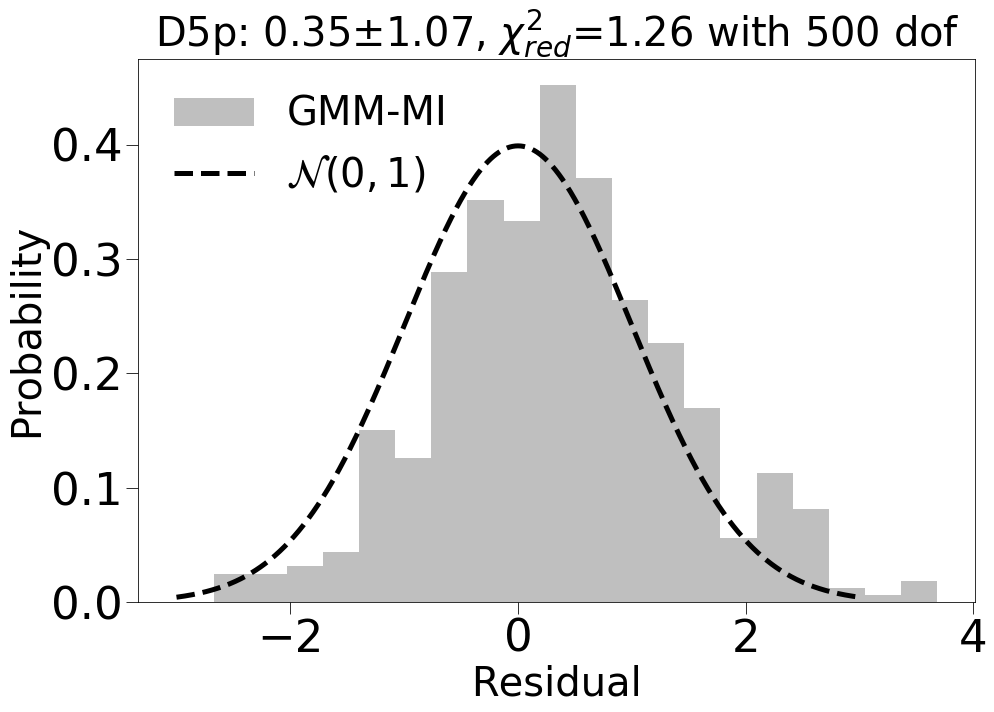

In [5]:
show_title=True
show_legend=True
hide_ylabel=False
labelfontsize=40
legendsize=40

biases, red_chi2, df = plot_bias_chi2_histogram(all_MI_estimates, analytic=analytic, 
                                                show_title=show_title, show_legend=show_legend, 
                                                hide_ylabel=hide_ylabel, labelfontsize=labelfontsize, 
                                                ds=label, legendsize=legendsize)